# Shopify Data Challenge

For this portion of the project, I decided to use a Jupyter Notebook and Python because of the ease of running cells and writing markup to annotate my code.

To run the Jupyter Notebook locally, download the repository and launch it through Jupyter Notebook. To install Jupyter Notebook, you can run the command 'pip install notebook' in terminal, and start the program by running 'jupyter notebook'. You can also run the Notebook through Google Colab or other similar online software.


## Question 1

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

- Think about what could be going wrong with our calculation.
- Think about a better way to evaluate this data. 
- What metric would you report for this dataset? What is its value?

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in csv
orders = pd.read_csv("shopify_data.csv")

orders.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


**Think about what could go wrong with our calculation.**

To first approach the problem, I sought to recreate the naive calculation of AOV. My first inclination was to take the average of the order_amount column of the dataframe. As expected, this resulted in the value of $3145.13 that was found in the initial analysis:

In [3]:
aov = orders.order_amount.mean()
print(f"Naive calculation of AOV: {aov}")

Naive calculation of AOV: 3145.128


There are a few reasons that this AOV calculation seems wrong. The order_amount column provides the value of the order for all items ordered by a shopper. We can see that total_items gives the number of items bought in a single order. Therefore, one of the reasons that the AOV seems high is that we are averaging the order amounts as if each item in the column represented the value of a single pair of shoes. Sneakers are a relatively affordable item, but we should not expect the AOV to reflect the average value of a single pair of sneakers when we average the order amounts which may have more than one ordered pair of shoes. This is an important clarification about the metric itself that we are using. The AOV can be used to determine customer behoviors when purchasing items, and so we need to consider when consumers are buying more than one item on the site.

This clarification about the AOV helps us consider why the data should be higher than the average pair of shoes, but it also helps us understand where the metric itself may be skewed. In this case, the data is influenced by outliers which is causing the value to seem extraordinarily high. We have to consider that the majority of consumers will likely only buy a few pairs of shoes per order, and not be buying in bulk. Further, there may be shoes from stores with unusually high prices. For example, a designer shoe may cost much more than the average sneaker, and this would be reflected in the average. Both of these factors would increase the AOV to an unusually high value.

**Think about a better way to evaluate the data.**

To better understand the data we are working with, it will be helpful to visualize the data. Below is a histogram with the distribution of total items per order, and beside it is a distribution of the order amounts. 

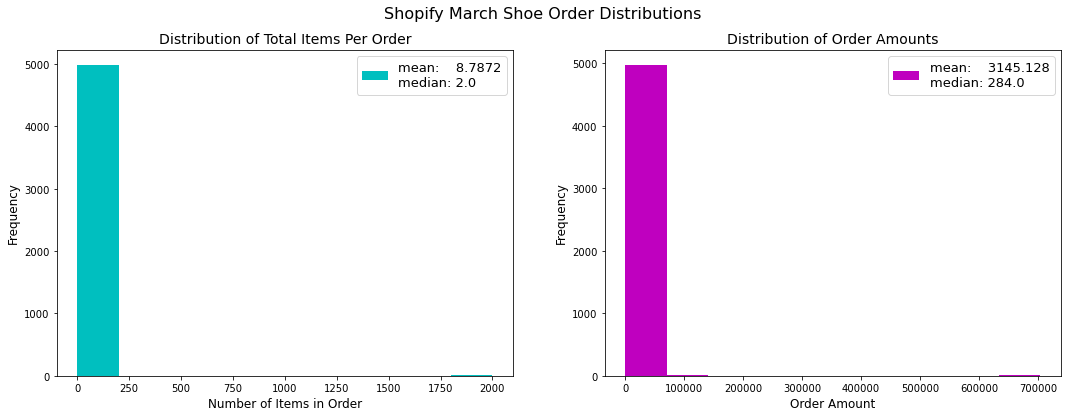

In [4]:
mov = orders.order_amount.median()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle('Shopify March Shoe Order Distributions', fontsize=16)

# items in order distribution
items_mean = orders.total_items.mean()
items_median = orders.total_items.median()

ax1.hist(orders.total_items, color="c", label=f"mean:    {items_mean}\nmedian: {items_median}")

ax1.set_title("Distribution of Total Items Per Order", fontsize=14)
ax1.set_xlabel("Number of Items in Order", fontsize=12)
ax1.set_ylabel("Frequency", fontsize=12)
ax1.legend(fontsize=13)

# amount ordered distribution
ax2.hist(orders.order_amount, color="m", label=f"mean:    {aov}\nmedian: {mov}")

ax2.set_title("Distribution of Order Amounts", fontsize=14)
ax2.set_xlabel("Order Amount", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
ax2.legend(fontsize=13)

plt.show()

Now that we see the data, we can see that our first initial assumption was correct. The AOV was being skewed by outlier data with a high number of items ordered, casuing the average order amount to be unusually high.

Our second assumption was that there may be extraordinarily high priced shoes. Since each shop sells only one model of shoe, we can find the price of the shoe that was sold from each store fairly easily by dividing the order amount by the total items ordered. Let's add the individual shoe price for each order as a column to the dataframe:

In [5]:
orders["shoe_price"] = orders.order_amount/orders.total_items

Let's again vizualize the distribution, this time with the prices of the individual shoe for each order:

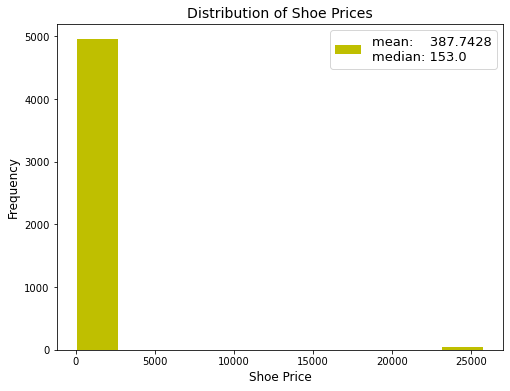

In [28]:
price_mean = orders.shoe_price.mean()
price_median = orders.shoe_price.median()

plt.figure(figsize=(8,6))

plt.hist(orders.shoe_price, color="y", label=f"mean:    {price_mean}\nmedian: {price_median}")

plt.title("Distribution of Shoe Prices", fontsize=14)
plt.xlabel("Shoe Price", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=13)

plt.show()

In [7]:
print(f"Most expensive pair of shoes ordered: ${orders.shoe_price.max()}")

Most expensive pair of shoes ordered: $25725.0


Here we can see that there was a purchase of shoes which had an extremely high value relative to the other pairs of shoes. This factor will also affect the average order value as the typical consumer will not be ordering a $25,725 dollar pair of shoes. We can also see that the mean is significantly higher than the median because of the outliers from this store.

With each of these data columns, I wanted to visualize the distributions with histograms so that we would have a better sense of how many outlier data points we had for each of these measures and where the majority of shoes were priced. This can be more helpful than just looking at the mean, median, maxima and minima because those values can be hard to interpret when trying to get a sense of the distribution of data. A boxplot can also be helpful as an alternative when looking at the quartile ranges, but with this data the outliers are so far out that the boxplot would look condensed and hard to read.

**What metric would you report for this dataset? What is its value?**

Knowing now that the issue lies in the outlier data, there are two strategies we can consider to find a better metric to improve on the AOV.

- [1] We can eliminate the outliers and recalculate the average order amount without the outlier data. This includes removing stores with outlier shoe prices and orders with outlier total number of orders.
- [2] We can take the median value of the order amount which would not be skewed by outliers in the same way that the mean would.

In [20]:
# strategy 1: remove outliers where outlier > Q3 + 1.5 x IQR

# outlier prices
q3_price = np.percentile(orders.shoe_price, 75)
iqr_price = np.subtract(*np.percentile(orders.shoe_price, [75, 25]))
outlier_price = q3_price + 1.5*iqr_price

# outlier shoe totals
q3_totals = np.percentile(orders.total_items, 75)
iqr_totals = np.subtract(*np.percentile(orders.total_items, [75, 25]))
outlier_totals = q3_totals + 1.5*iqr_totals

outlier_mask = (orders.shoe_price < outlier_price) & (orders.total_items < outlier_totals)

orders_no_outliers = orders[outlier_mask]

# take the mean of order amount without the outliers
new_aov = orders_no_outliers.order_amount.mean()

In [22]:
# strategy 2: take median of original order amount table
median_order_amount = orders.order_amount.median()

In [57]:
print(f"New average shoe price: ${round(orders_no_outliers.shoe_price.mean(), 2)}")
print(f"Average total items: {round(orders_no_outliers.total_items.mean(), 2)}")

New average shoe price: $150.41
Average total items: 1.99


In [54]:
print(f"Metric 1 (AOV no outliers):     ${round(new_aov,2)}")
print(f"Metric 2 (median order amount): ${median_order_amount}")

Metric 1 (AOV no outliers):     $299.04
Metric 2 (median order amount): $284.0


In [61]:
revenue_difference = np.sum(orders.order_amount) - np.sum(orders_no_outliers.order_amount)
percent_revs_outliers = 100 * revenue_difference / np.sum(orders.order_amount)
print("Difference in revenue with outliers and without: ${:,.2f}".format(revenue_difference))
print(f"Percent of revenues from outlier data: {round(percent_revs_outliers)}%")

Difference in revenue with outliers and without: $14,262,150.00
Percent of revenues from outlier data: 91%


For this dataset, I would report the AOV without outliers. This is the closest metric we have to the original AOV and will be the most useful factor when trying to drive product insight. The new AOV is much closer to the original median order amount, which is a sign that fixing the outlier problem drastically improved the usefulness of the AOV metric.

The new AOV without outliers is about $299.

For a quick interpretation of this metric, we can compare this value to the average shoe price (from the data with removed outliers) to gain insight on customer behavior. Since the average shoe costs about $150, this means the average consumer is buying about 2 pairs of shoes per order (also verified by the average of total items bought per order).

I would also be remiss if I did not address one very important question of this analysis. That is, why was the AOV so high to begin with? More specifically, if the majority of revenue came from consumer buyers who are purchasing about 2 pairs of shoes on average, then the AOV would not be skewed so high. How should we address this?

When trying to get an idea of typical consumer behavior, the AOV metric without outliers is a great metric to use. However, if want to figure out where the majority of total revenue is coming from, we want to consider the outliers because they drastically change the revenue. The outliers boost the total revenues from the stores by about 14 million. A different way of looking at that number is that about 91% of the revenues are coming from outlier data (bulk and luxury shoe buyers).

Therefore, depending on what type of insight we need on shopper data, we should consider different metrics. The AOV without outliers is great for analyzing the average consumer buying habits. However, the outlier data makes up 91% of the combined revenues from the stores, so in a different context that metric is important as well because it may tell us to focus energy into building the shopify experience for large buyers (not to say we should neglect small buyers, just that we may want to redistribute resources if big shoppers are not ).